In [8]:
#need volatility data and the data from the risk_adjusted_returns file:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Get volatility historical data:
url_volatility = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/volatility_data.csv'
volatility_df = pd.read_csv(url_volatility)
#make the date a datetime object:
volatility_df['Date'] = pd.to_datetime(volatility_df['Date'])

# first we need the historical data: 
url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/Nasdaq100_price_data.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.head()
#this dataset includes the prices and the volume!
# we now need to calculate the returns, do this by taking the logarithm and first difference of the closing price.
price_df['r_ndq'] = np.log(price_df['Close']).diff() #not times 100 for dgf for now
price_df.dropna(inplace=True)
price_df.head()

rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/US%2010%20Year%20T-Note%20Futures%20Historical%20Data.csv')
rf_df['r_rf'] = np.log(rf_df['Price']).diff()
rf_df.dropna(inplace=True)
rf_df['Date'] = pd.to_datetime(rf_df['Date'])

portfolio_df = pd.merge(price_df[['Date', 'r_ndq']], 
                     rf_df[['Date', 'r_rf']], 
                     on='Date', 
                     how='inner')

portfolio_df = pd.merge(portfolio_df,  
                     volatility_df[['Date', 'Price']],
                     on='Date', 
                     how='inner')

portfolio_df.rename(columns={'Price' : 'Volatility'}, inplace = True)
portfolio_df.head()

,Date,r_ndq,r_rf,Volatility
0,2015-01-02,-0.001427,-0.004786,16.59
1,2015-01-05,-0.016513,-0.004607,18.00
2,2015-01-06,-0.012121,-0.000857,19.05
3,2015-01-07,0.011890,0.002806,17.20
4,2015-01-08,0.019178,-0.003662,16.61


In [19]:
r = 14
s = 16
w_ndq = []
w_rf = []
for i in range(len(portfolio_df)):
    if portfolio_df['Volatility'][i] > s:
        w_ndq.append(0)
        w_rf.append(1)
    elif (portfolio_df['Volatility'][i] <= s) and (portfolio_df['Volatility'][i] > r):
        w_ndq.append(0.6)
        w_rf.append(0.4)
    else:
        w_ndq.append(1)
        w_rf.append(0)

In [20]:
len(w_rf)

1257

In [21]:
w_rf = np.array(w_rf)
w_ndq = np.array(w_ndq)

In [22]:
w_ndq

array([0. , 0. , 0. , ..., 1. , 0.6, 0.6])

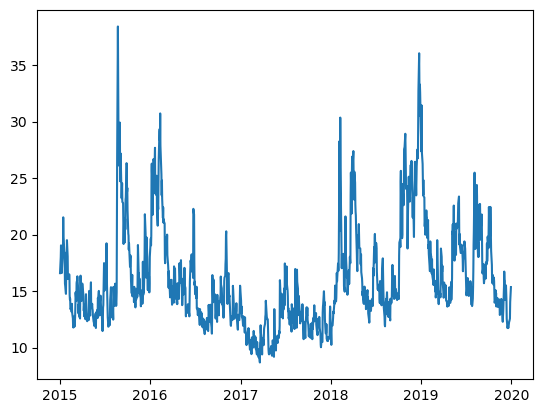

In [23]:
plt.plot(portfolio_df['Date'], portfolio_df['Volatility'])

In [13]:
len(portfolio_df)

1257

Next, calculate the portfolio returns based on the weights:
- best way: add the weights as columns in the dataframe?

In [24]:
# Adding arrays as columns to the DataFrame
portfolio_df['w_ndq'] = w_ndq
portfolio_df['w_rf'] = w_rf

portfolio_df.head()

,Date,r_ndq,r_rf,Volatility,w_ndq,w_rf
0,2015-01-02,-0.001427,-0.004786,16.59,0.0,1.0
1,2015-01-05,-0.016513,-0.004607,18.00,0.0,1.0
2,2015-01-06,-0.012121,-0.000857,19.05,0.0,1.0
3,2015-01-07,0.011890,0.002806,17.20,0.0,1.0
4,2015-01-08,0.019178,-0.003662,16.61,0.0,1.0


In [25]:
portfolio_df['r_portfolio'] = portfolio_df['w_ndq']*portfolio_df['r_ndq'] + portfolio_df['w_rf']*portfolio_df['r_rf']

In [26]:
portfolio_df.head()

,Date,r_ndq,r_rf,Volatility,w_ndq,w_rf,r_portfolio
0,2015-01-02,-0.001427,-0.004786,16.59,0.0,1.0,-0.004786
1,2015-01-05,-0.016513,-0.004607,18.00,0.0,1.0,-0.004607
2,2015-01-06,-0.012121,-0.000857,19.05,0.0,1.0,-0.000857
3,2015-01-07,0.011890,0.002806,17.20,0.0,1.0,0.002806
4,2015-01-08,0.019178,-0.003662,16.61,0.0,1.0,-0.003662


In [37]:
r_rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/GS1M.csv')
#divide by 12 to get monthly returns instead of annual:
#divide gs1m by 100 because it was already in % -> we dont want that here!
r_rf_df['monthly_rf'] = (1 + (r_rf_df['GS1M']/100))**(1/12) -1
r_rf_df.rename(columns = {'DATE':'Date'}, inplace = True)
r_rf_df['Date'] = pd.to_datetime(r_rf_df['Date'])
r_rf_df.head()

,Date,GS1M,monthly_rf
0,2015-01-01,0.02,0.000017
1,2015-02-01,0.02,0.000017
2,2015-03-01,0.02,0.000017
3,2015-04-01,0.02,0.000017
4,2015-05-01,0.01,0.000008


In [50]:
import numpy as np
import pandas as pd
from itertools import product

def calculate_total_return(r, s):
    w_ndq = []
    w_rf = []
    for volatility in portfolio_df['Volatility']:
        if volatility > s:
            w_ndq.append(0)
            w_rf.append(1)
        elif volatility <= s and volatility > r:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        else:
            w_ndq.append(1)
            w_rf.append(0)
    portfolio_df['w_ndq'] = w_ndq
    portfolio_df['w_rf'] = w_rf
    portfolio_df['r_portfolio'] = portfolio_df['w_ndq'] * portfolio_df['r_ndq'] + portfolio_df['w_rf'] * portfolio_df['r_rf']
    return portfolio_df['r_portfolio'].sum()

# Define ranges for r and s
r_values = np.linspace(5, 20, 21)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(6, 30, 21)  # from 10 to 20 in 0.5 increments

# Grid search
max_return = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    if s > r:  # Ensure s is always greater than r
        total_return = calculate_total_return(r, s)
        if total_return > max_return:
            max_return = total_return
            best_r, best_s = r, s

print(f'Best r: {best_r}, Best s: {best_s}, Maximized Total Return: {max_return}')


Best r: 16.25, Best s: 19.2, Maximized Total Return: 1.4795616949438566


In [28]:
portfolio_df.head()

,Date,r_ndq,r_rf,Volatility,w_ndq,w_rf,r_portfolio
0,2015-01-02,-0.001427,-0.004786,16.59,0.6,0.4,-0.002770
1,2015-01-05,-0.016513,-0.004607,18.00,0.6,0.4,-0.011751
2,2015-01-06,-0.012121,-0.000857,19.05,0.6,0.4,-0.007615
3,2015-01-07,0.011890,0.002806,17.20,0.6,0.4,0.008257
4,2015-01-08,0.019178,-0.003662,16.61,0.6,0.4,0.010042


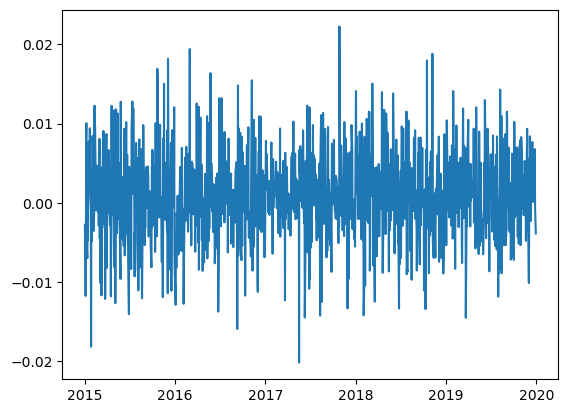

In [32]:
plt.plot(portfolio_df['Date'], portfolio_df['r_portfolio'])

In [ ]:
plt.plot(portfolio_df['Date'], portfolio_df['Volatility'])
plt.plot(portfolio_df[''])

In [30]:
portfolio_df.sum()

C:\Users\ingam\AppData\Local\Temp\ipykernel_16252\3742371718.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  portfolio_df.sum()


r_ndq              0.720755
r_rf               0.015375
Volatility     20055.020000
w_ndq            896.000000
w_rf             361.000000
r_portfolio        1.394786
dtype: float64

Based on Sharpe:

In [67]:
import numpy as np
import pandas as pd
from itertools import product

def calculate_average_sharpe(r, s):
    w_ndq = []
    w_rf = []
    for volatility in portfolio_df['Volatility']:
        if volatility > s:
            w_ndq.append(0)
            w_rf.append(1)
        elif volatility <= s and volatility > r:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        else:
            w_ndq.append(1)
            w_rf.append(0)
    portfolio_df['w_ndq'] = w_ndq
    portfolio_df['w_rf'] = w_rf
    portfolio_df['r_portfolio'] = portfolio_df['w_ndq'] * portfolio_df['r_ndq'] + portfolio_df['w_rf'] * portfolio_df['r_rf']
    portfolio_df['dgf_portfolio'] = 1 + portfolio_df['r_portfolio']
    #calculate monthly returns and stuff for sharpe:
    # Resample the data by month and calculate mean and standard deviation for specific columns
    monthly_stats = portfolio_df.resample('M').agg({
        'r_ndq': ['mean', 'std'],
        'r_rf': ['mean', 'std'],
        'r_portfolio': 'mean',
        'dgf_portfolio': 'prod',
        'w_ndq': 'mean',
        'w_rf': 'mean'
        })


    # Flatten the MultiIndex in columns created by agg()
    monthly_stats.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in monthly_stats.columns.values]

    grouped = portfolio_df.resample('M')
    covariances = []
    for month in grouped:
        cov = np.cov(month[1]['r_ndq'], month[1]['r_rf'])[0,1]
        row = {'Date': month[0], 'covariance': cov}
        covariances.append(row)

    covariances = pd.DataFrame(covariances)
    covariances.set_index('Date', inplace=True)

    # Combine the results
    monthly_stats = pd.concat([monthly_stats, covariances], axis=1)
    monthly_stats['monthly_returns_portfolio'] = monthly_stats['dgf_portfolio_prod'] - 1
    #calculate standard deviation of the portfolio per month:

    monthly_stats['std_portfolio'] = np.sqrt(monthly_stats['w_ndq_mean']**2*monthly_stats['r_ndq_std']**2 + monthly_stats['w_rf_mean']**2*monthly_stats['r_rf_std']**2 + 2*monthly_stats['w_ndq_mean']*monthly_stats['w_rf_mean']*monthly_stats['covariance'])
    monthly_stats = monthly_stats.reset_index()
    monthly_stats['Date'] = pd.to_datetime(monthly_stats['Date']).dt.to_period('M').dt.to_timestamp().dt.date
    monthly_stats['Date'] = pd.to_datetime(monthly_stats['Date'])
    sharpe_df = pd.merge(monthly_stats, r_rf_df, on='Date', how='left')
    sharpe_df['risk_premium'] = sharpe_df['monthly_returns_portfolio'] - sharpe_df['monthly_rf']
    sharpe_df['sharpe_ratio'] = sharpe_df['risk_premium']/(sharpe_df['std_portfolio']*100)
    return np.average(sharpe_df['sharpe_ratio']), sharpe_df

# Define ranges for r and s
r_values = np.linspace(5, 20, 21)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(6, 30, 21)  # from 10 to 20 in 0.5 increments

# Grid search
max_sharpe = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    if s > r:  # Ensure s is always greater than r
        average_sharpe, sharpe_df = calculate_average_sharpe(r, s)
        if average_sharpe > max_sharpe:
            max_sharpe = average_sharpe
            sharpe_df = sharpe_df
            best_r, best_s = r, s

print(f'Best r: {best_r}, Best s: {best_s}, Maximized average Sharpe ratio (%): {max_sharpe*100}')


Best r: 14.0, Best s: 14.4, Maximized average Sharpe ratio (%): 4.30453554330433


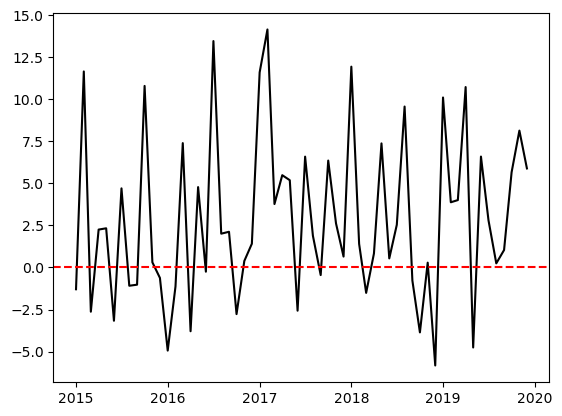

In [56]:
plt.plot(sharpe_df['Date'], sharpe_df['sharpe_ratio']*100, color = 'black')
plt.axhline(0, color = 'red', linestyle = '--')

In [58]:
sharpe_df['w_ndq_mean'].mean()

0.9298436291651394

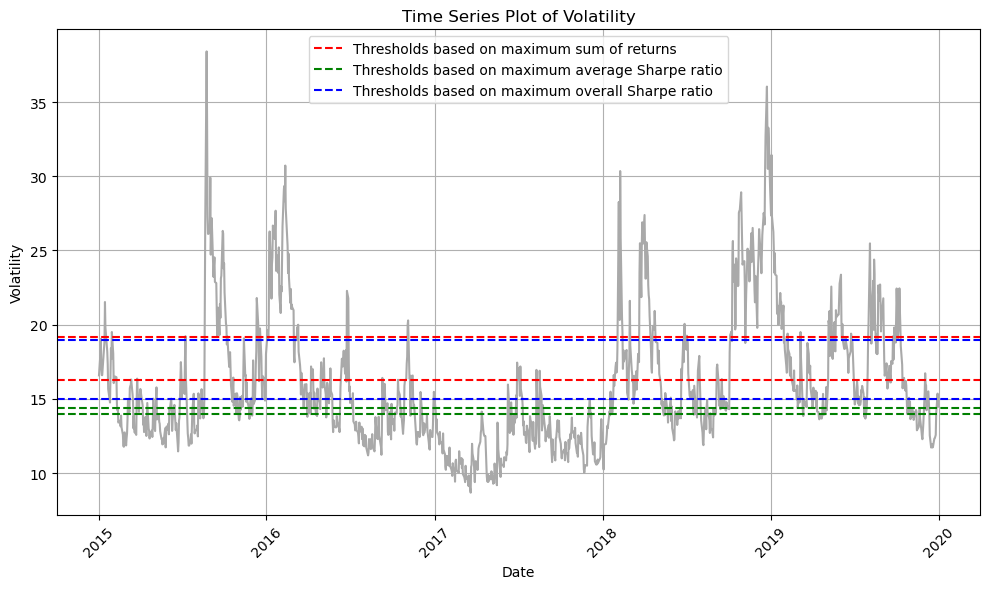

In [85]:
# Plotting the Volatility over time
plt.figure(figsize=(10, 6))  # Setting the figure size
plt.plot(volatility_df['Date'], volatility_df['Price'], linestyle='-', color='darkgray')  # Plotting data
plt.axhline(16.25, color = 'red', linestyle = '--', label='Thresholds based on maximum sum of returns')
plt.axhline(19.2, color = 'red', linestyle = '--')
plt.axhline(14, color = 'green', linestyle = '--', label='Thresholds based on maximum average Sharpe ratio')
plt.axhline(14.4, color = 'green', linestyle = '--')
plt.axhline(15, color = 'blue', linestyle = '--', label='Thresholds based on maximum overall Sharpe ratio')
plt.axhline(19, color = 'blue', linestyle = '--')
plt.legend()
plt.title('Time Series Plot of Volatility')  # Adding a title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Volatility')  # Y-axis label
plt.grid(True)  # Adding a grid for better readability
plt.xticks(rotation=45)  # Rotating X-axis labels for better readability
plt.tight_layout()  # Adjusting the layout to make room for the rotated x-axis labels

# Displaying the plot
plt.show()

In [62]:
sharpe_df['w_rf_mean'].mean()

0.07015637083486054

Next: do the exact same thing except use annualized sharpe ratios before averaging:

In [68]:
import numpy as np
import pandas as pd
from itertools import product

def calculate_average_annualized_sharpe(r, s):
    w_ndq = []
    w_rf = []
    for volatility in portfolio_df['Volatility']:
        if volatility > s:
            w_ndq.append(0)
            w_rf.append(1)
        elif volatility <= s and volatility > r:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        else:
            w_ndq.append(1)
            w_rf.append(0)
    portfolio_df['w_ndq'] = w_ndq
    portfolio_df['w_rf'] = w_rf
    portfolio_df['r_portfolio'] = portfolio_df['w_ndq'] * portfolio_df['r_ndq'] + portfolio_df['w_rf'] * portfolio_df['r_rf']
    portfolio_df['dgf_portfolio'] = 1 + portfolio_df['r_portfolio']
    #calculate monthly returns and stuff for sharpe:
    # Resample the data by month and calculate mean and standard deviation for specific columns
    monthly_stats = portfolio_df.resample('M').agg({
        'r_ndq': ['mean', 'std'],
        'r_rf': ['mean', 'std'],
        'r_portfolio': 'mean',
        'dgf_portfolio': 'prod',
        'w_ndq': 'mean',
        'w_rf': 'mean'
        })


    # Flatten the MultiIndex in columns created by agg()
    monthly_stats.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in monthly_stats.columns.values]

    grouped = portfolio_df.resample('M')
    covariances = []
    for month in grouped:
        cov = np.cov(month[1]['r_ndq'], month[1]['r_rf'])[0,1]
        row = {'Date': month[0], 'covariance': cov}
        covariances.append(row)

    covariances = pd.DataFrame(covariances)
    covariances.set_index('Date', inplace=True)

    # Combine the results
    monthly_stats = pd.concat([monthly_stats, covariances], axis=1)
    monthly_stats['monthly_returns_portfolio'] = monthly_stats['dgf_portfolio_prod'] - 1
    #calculate standard deviation of the portfolio per month:

    monthly_stats['std_portfolio'] = np.sqrt(monthly_stats['w_ndq_mean']**2*monthly_stats['r_ndq_std']**2 + monthly_stats['w_rf_mean']**2*monthly_stats['r_rf_std']**2 + 2*monthly_stats['w_ndq_mean']*monthly_stats['w_rf_mean']*monthly_stats['covariance'])
    monthly_stats = monthly_stats.reset_index()
    monthly_stats['Date'] = pd.to_datetime(monthly_stats['Date']).dt.to_period('M').dt.to_timestamp().dt.date
    monthly_stats['Date'] = pd.to_datetime(monthly_stats['Date'])
    sharpe_df = pd.merge(monthly_stats, r_rf_df, on='Date', how='left')
    sharpe_df['risk_premium'] = sharpe_df['monthly_returns_portfolio'] - sharpe_df['monthly_rf']
    sharpe_df['sharpe_ratio'] = sharpe_df['risk_premium']/(sharpe_df['std_portfolio']*100)
    return np.average(sharpe_df['sharpe_ratio'])*np.sqrt(12), sharpe_df

# Define ranges for r and s
r_values = np.linspace(5, 20, 21)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(6, 30, 21)  # from 10 to 20 in 0.5 increments

# Grid search
max_sharpe = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    if s > r:  # Ensure s is always greater than r
        average_annualized_sharpe, sharpe_df = calculate_average_annualized_sharpe(r, s)
        if average_annualized_sharpe > max_sharpe:
            max_sharpe = average_annualized_sharpe
            sharpe_df = sharpe_df
            best_r, best_s = r, s

print(f'Best r: {best_r}, Best s: {best_s}, Maximized average annualized Sharpe ratio (%): {max_sharpe}')


Best r: 14.0, Best s: 14.4, Maximized average annualized Sharpe ratio (%): 0.149113485279784


Other option: cumulative metric: sharpe ratio over entire period:

In [69]:
# need mean risk free rate:
mean_rf = r_rf_df['monthly_rf'].mean()

In [84]:
import numpy as np
import pandas as pd
from itertools import product

def calculate_overall_sharpe(r, s):
    w_ndq = []
    w_rf = []
    for volatility in portfolio_df['Volatility']:
        if volatility > s:
            w_ndq.append(0)
            w_rf.append(1)
        elif volatility <= s and volatility > r:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        else:
            w_ndq.append(1)
            w_rf.append(0)
    portfolio_df['w_ndq'] = w_ndq
    portfolio_df['w_rf'] = w_rf
    portfolio_df['r_portfolio'] = portfolio_df['w_ndq'] * portfolio_df['r_ndq'] + portfolio_df['w_rf'] * portfolio_df['r_rf']
    portfolio_df['dgf_portfolio'] = 1 + portfolio_df['r_portfolio']
    #calculate monthly returns and stuff for sharpe:
    # Resample the data by month and calculate mean and standard deviation for specific columns
    monthly_stats = portfolio_df.resample('M').agg({
        'r_ndq': ['mean', 'std'],
        'r_rf': ['mean', 'std'],
        'r_portfolio': 'mean',
        'dgf_portfolio': 'prod',
        'w_ndq': 'mean',
        'w_rf': 'mean'
        })


    # Flatten the MultiIndex in columns created by agg()
    monthly_stats.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in monthly_stats.columns.values]

    grouped = portfolio_df.resample('M')
    covariances = []
    for month in grouped:
        cov = np.cov(month[1]['r_ndq'], month[1]['r_rf'])[0,1]
        row = {'Date': month[0], 'covariance': cov}
        covariances.append(row)

    covariances = pd.DataFrame(covariances)
    covariances.set_index('Date', inplace=True)

    # Combine the results
    monthly_stats = pd.concat([monthly_stats, covariances], axis=1)
    monthly_stats['monthly_returns_portfolio'] = monthly_stats['dgf_portfolio_prod'] - 1
    risk_premium = monthly_stats['monthly_returns_portfolio'].mean() - mean_rf
    std_p = np.std(monthly_stats['monthly_returns_portfolio'])
    sharpe_ratio = risk_premium/std_p
    return sharpe_ratio

# Define ranges for r and s
r_values = np.linspace(10, 20, 51)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(11, 30, 96)  # from 10 to 20 in 0.5 increments

# Grid search
max_sharpe = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    if s > r:  # Ensure s is always greater than r
        overall_sharpe = calculate_overall_sharpe(r, s)
        if overall_sharpe > max_sharpe:
            max_sharpe = overall_sharpe
            best_r, best_s = r, s

print(f'Best r: {best_r}, Best s: {best_s}, Maximized overall Sharpe ratio (%): {max_sharpe*100}')


Best r: 15.0, Best s: 19.0, Maximized overall Sharpe ratio (%): 95.82730836513977


benchmark model gives overall sharpe: 22.90%

In [74]:
np.linspace?

Signature:
np.linspace(
    start,
    stop,
    num=50,
    endpoint=True,
    retstep=False,
    dtype=None,
    axis=0,
)
Docstring:
Return evenly spaced numbers over a specified interval.

Returns `num` evenly spaced samples, calculated over the
interval [`start`, `stop`].

The endpoint of the interval can optionally be excluded.

.. versionchanged:: 1.16.0
    Non-scalar `start` and `stop` are now supported.

.. versionchanged:: 1.20.0
    Values are rounded towards ``-inf`` instead of ``0`` when an
    integer ``dtype`` is specified. The old behavior can
    still be obtained with ``np.linspace(start, stop, num).astype(int)``

Parameters
----------
start : array_like
    The starting value of the sequence.
stop : array_like
    The end value of the sequence, unless `endpoint` is set to False.
    In that case, the sequence consists of all but the last of ``num + 1``
    evenly spaced samples, so that `stop` is excluded.  Note that the step
    size changes when `endpoint` is Fals